In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import hdstats
import joblib

In [4]:
data = joblib.load('../tests/landchar-small.pkl')

In [5]:
np.count_nonzero(np.isnan(data).any(axis=2))

0

In [6]:
data = hdstats.completion(data)

In [7]:
np.count_nonzero(np.isnan(data).any(axis=2))

0

In [8]:
gm = hdstats.nangeomedian_pcm(data, num_threads=28)

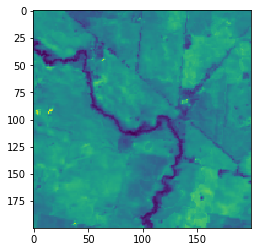

In [9]:
plt.imshow(gm[:,:,0])

In [10]:
mm = np.nanmean(data, axis=3)

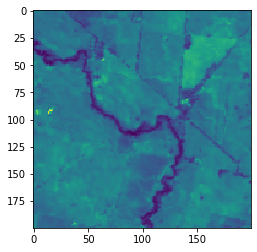

In [11]:
plt.imshow(mm[:,:,0])

In [12]:
yloc, xloc = data.shape[0]//2, data.shape[1]//2

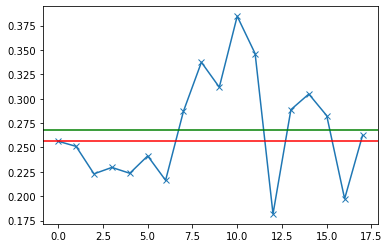

In [13]:
plt.plot(data[yloc,xloc,4,:], marker='x')
plt.axhline(gm[yloc,xloc,4], c='r')
plt.axhline(mm[yloc,xloc,4], c='g')

In [14]:
cdts = hdstats.cosdist(data, gm, num_threads=28)

Using 1 threads


In [15]:
edts = hdstats.eucdist(data, gm, num_threads=28)

Using 1 threads


In [145]:
ndvi = (data[:,:,3,:]-data[:,:,2,:])/(data[:,:,3,:]+data[:,:,2,:])

In [146]:
ndwi = (data[:,:,4,:]-data[:,:,3,:])/(data[:,:,4,:]+data[:,:,3,:])

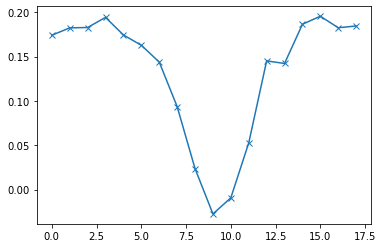

In [150]:
plt.plot(ndvi[yloc,xloc,:], marker='x')

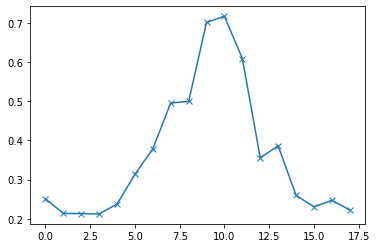

In [151]:
plt.plot(ndwi[yloc,xloc,:], marker='x')

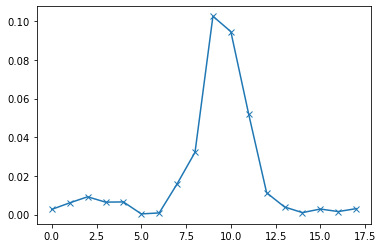

In [147]:
plt.plot(cdts[yloc,xloc,:], marker='x')

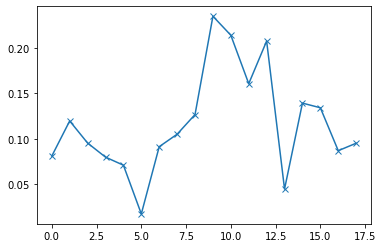

In [148]:
plt.plot(edts[yloc,xloc,:], marker='x')

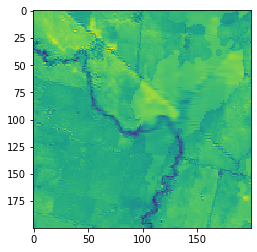

In [152]:
plt.imshow(ndvi[:,:,0]);

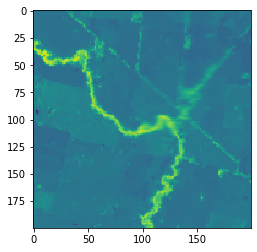

In [153]:
plt.imshow(ndwi[:,:,0]);

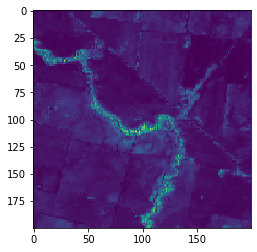

In [154]:
plt.imshow(cdts[:,:,15]);

In [155]:
def imshow(data, fs=6, pc=2):
    img = data.copy()
    plt.figure(figsize=(fs,fs*(img.shape[0]/img.shape[1])))

    if len(img.shape) == 3:
        for i in range(min(3, img.shape[2])):
            dd=img[:,:,i]
            pl, pu = np.percentile(dd[np.isfinite(dd)], (pc,100-pc))
            dd[dd<pl], dd[dd>pu] = pl, pu
            dd -= pl
            dd /= (pu - pl)
        plt.imshow(img, aspect='auto')
    else:
        pl, pu = np.percentile(img[np.isfinite(img)], (pc,100-pc))
        plt.imshow(img, aspect='auto', vmin=pl, vmax=pu)
    plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
    plt.tight_layout()
    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


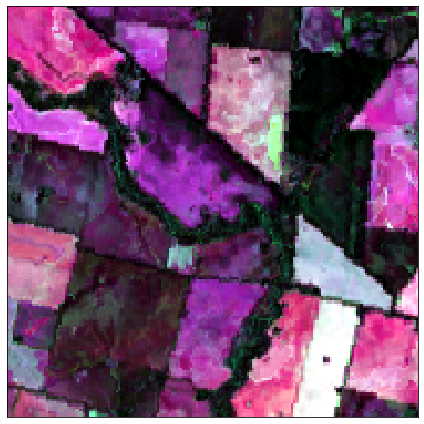

In [156]:
f1 = hdstats.fouriersum(cdts)
imshow(f1);

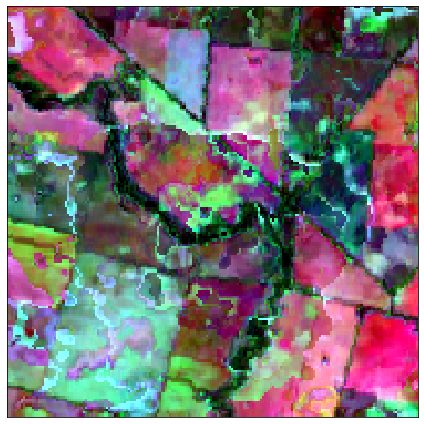

In [157]:
f2 = hdstats.fouriersum(edts)
imshow(f2);

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


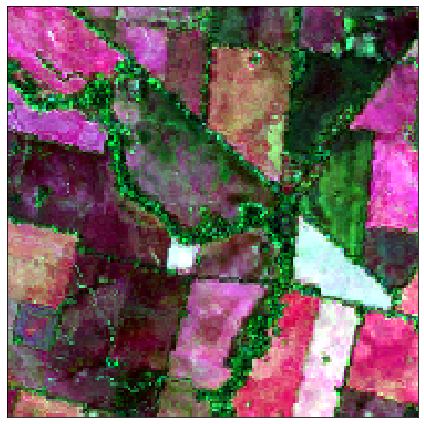

In [158]:
f3 = hdstats.fouriersum(ndvi)
imshow(f3);

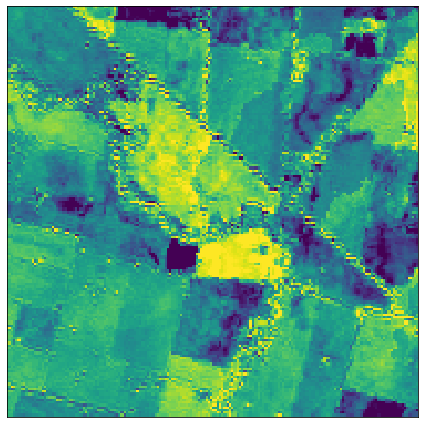

In [159]:
f4 = hdstats.mean_change(ndvi)
imshow(f4);

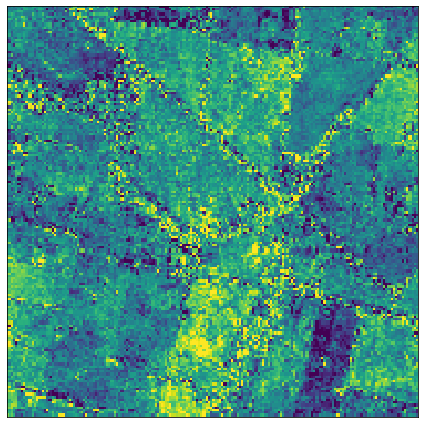

In [161]:
f5 = hdstats.median_change(ndvi)
imshow(f5);

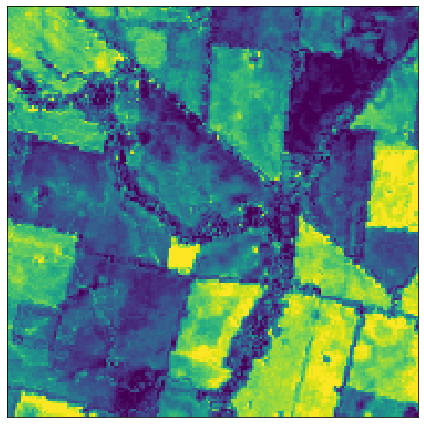

In [162]:
f6 = hdstats.mean_abs_change(ndvi)
imshow(f6);

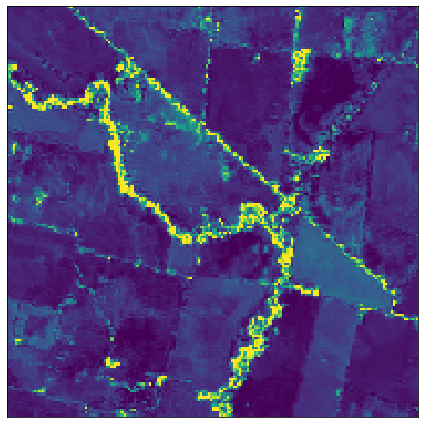

In [163]:
f7 = hdstats.complexity(ndvi)
imshow(f7);

In [164]:
f8 = hdstats.symmetry(data)

Using 1 threads


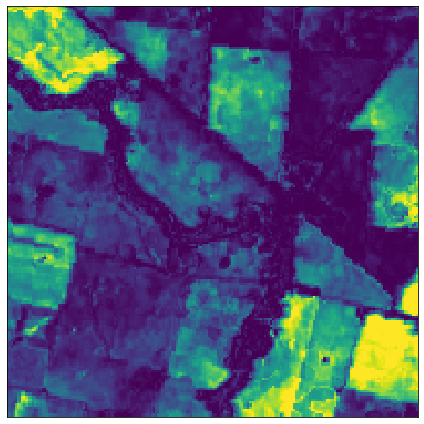

In [165]:
imshow(f8);

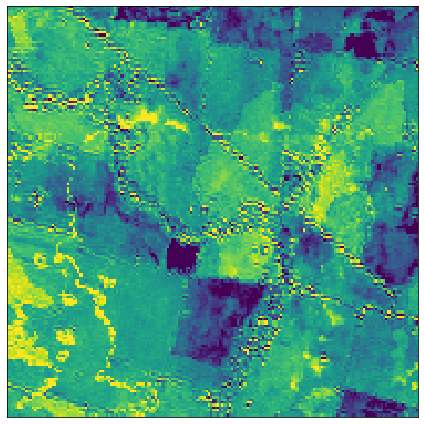

In [166]:
f9 = hdstats.mean_central_diff(ndvi)
imshow(f9);

In [168]:
mndvi = np.mean(ndvi, axis=(0,1))

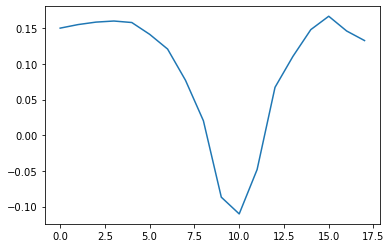

In [169]:
plt.plot(mndvi)

In [170]:
hdstats.number_peaks(mndvi[np.newaxis,np.newaxis,:], 20)

array([[2]], dtype=int8)

In [173]:
f10 = hdstats.number_peaks(ndvi, 20)

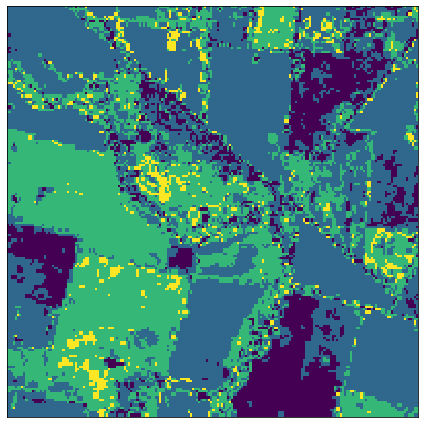

In [180]:
imshow(f10);

In [175]:
f11 = hdstats.discordance(cdts)

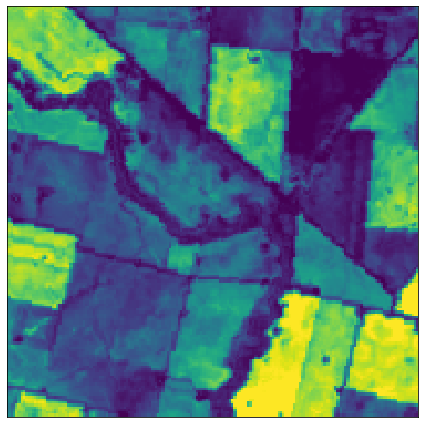

In [176]:
imshow(f11);

In [181]:
mdtw = np.empty(ndvi.shape[:2], dtype=np.float32)
for i in range(mdtw.shape[0]):
    for j in range(mdtw.shape[1]):
        mdtw[i,j] = hdstats.dtw_dist(mndvi.reshape(1,-1), ndvi[i,j,:].reshape(1,-1))

In [182]:
f12 = mdtw

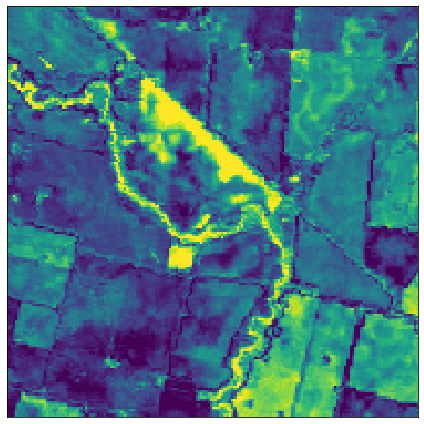

In [183]:
imshow(mdtw);

In [184]:
img = np.dstack([f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12])

In [185]:
np.count_nonzero(np.isnan(img))

0

In [188]:
A = img.reshape((-1, img.shape[-1]))

Text(0, 0.5, 'range(1, 19)')

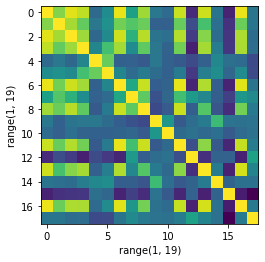

In [189]:
plt.imshow(np.corrcoef(A.T))
plt.xlabel(range(1, img.shape[-1]+1))
plt.ylabel(range(1, img.shape[-1]+1))

In [190]:
imgos = img.shape
X = img.reshape((-1, img.shape[-1])).copy()

In [191]:
X.shape

(40000, 18)

In [192]:
mask = np.isfinite(img).all(axis=2)

In [193]:
mask.shape

(200, 200)

In [275]:
from sklearn.pipeline import Pipeline
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA, FactorAnalysis

nfeatures = X.shape[1]

pipeline = []

pca = PCA(n_components=8, svd_solver="randomized", whiten=True)
pipeline.append(("pca", pca))

gmm = GaussianMixture(n_components=20, covariance_type="full", verbose=True, init_params="random")

pipeline.append(("gmm", gmm))

classifier = Pipeline(pipeline)

classifier.fit(X[mask.flat])

Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
Initialization converged: True


Pipeline(memory=None,
         steps=[('pca',
                 PCA(copy=True, iterated_power='auto', n_components=8,
                     random_state=None, svd_solver='randomized', tol=0.0,
                     whiten=True)),
                ('gmm',
                 GaussianMixture(covariance_type='full', init_params='random',
                                 max_iter=100, means_init=None, n_components=20,
                                 n_init=1, precisions_init=None,
                                 random_state=None, reg_covar=1e-06, tol=0.001,
                                 verbose=True, verbose_interval=10,
                                 warm_start=False, weights_init=None))],
         verbose=False)

In [276]:
labels = np.zeros((imgos[0], imgos[1]), dtype=np.uint8)
labels[mask] = classifier.predict(X[mask.flat])

In [277]:
np.unique(labels)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19], dtype=uint8)

In [278]:
from skimage.morphology import (label, convex_hull_object, binary_closing, binary_opening,
 square, remove_small_objects, binary_erosion, diameter_closing, diamond)

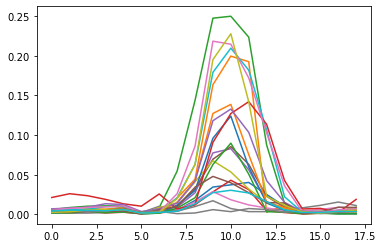

In [279]:
for i in np.unique(labels):
    plt.plot(np.mean(cdts[labels==i,:], axis=0), label=i)
#plt.legend()

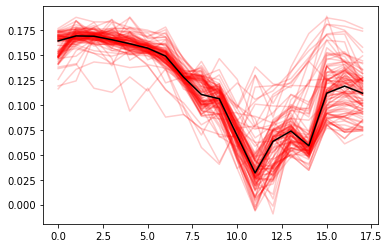

In [280]:
series = ndvi[labels==17,:]
idxs = np.random.randint(0, series.shape[0], size=100)

t = range(series.shape[1])

for ts in series[idxs]:
    plt.plot(t, ts, color='r', alpha=0.2)
    
plt.plot(t, np.median(series[idxs], axis=0), color='k')

In [281]:
classes = np.unique(labels)

In [282]:
stdevs = []
for label in classes:
    series = ndvi[labels==label,:]
    idxs = np.random.randint(0, series.shape[0], size=100)
    stdevs.append(np.mean(np.std(series[idxs], axis=0)))
idx = np.argsort(stdevs)

In [283]:
idx[:20]

array([17,  2, 12, 15, 10,  1, 18, 16,  8, 11,  3,  5,  9, 19,  0, 13, 14,
        7,  4,  6])

In [284]:
ndviphenos = [np.mean(ndvi[labels==i,:], axis=0).reshape(1,-1) for i in idx[:20]]

In [285]:
ntc = np.empty((ndvi.shape[0], ndvi.shape[1], len(ndviphenos)), dtype=np.float32)
for k in range(ntc.shape[2]):
    print(k)
    for i in range(ntc.shape[0]):
        for j in range(ntc.shape[1]):
            ntc[i,j,k] = hdstats.dtw_dist(ndvi[i,j,:].reshape(1,-1), ndviphenos[k])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [286]:
mntc = np.argmin(ntc, axis=2)

In [287]:
dtwlabels = np.zeros_like(mntc)
for k in np.unique(mntc):
    lmask = mntc == k
    lmask = binary_closing(lmask, diamond(2))
    dtwlabels[lmask] = k

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


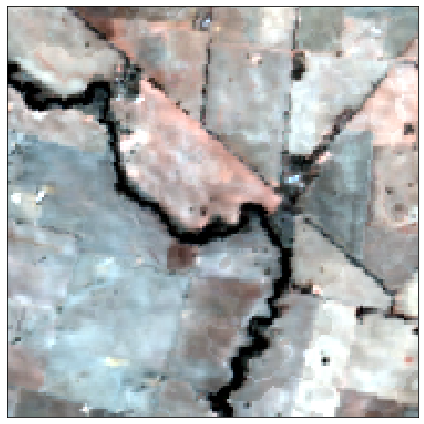

In [288]:
imshow(gm[:,:,[2,1,0]]);

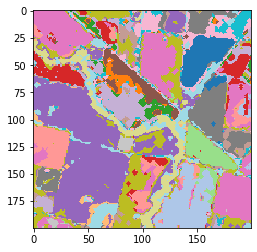

In [289]:
plt.imshow(dtwlabels, cmap=plt.cm.tab20)
#plt.colorbar()

In [290]:
clabels = np.zeros_like(labels)
for k in reversed(range(len(classes))[:20]):
    lmask = labels == classes[idx[k]]
    lmask = binary_closing(lmask, diamond(2))
    clabels[lmask] = k

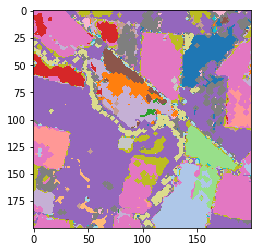

In [291]:
plt.imshow(clabels, cmap=plt.cm.tab20)
#plt.colorbar()